In [9]:
from pathlib import Path

!pip install cf_xarray

import cartopy
import cartopy.crs as ccrs
import cf_xarray  # noqa: F401
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rioxarray as rio
import xarray as xr
from rasterio.enums import Resampling
from rasterio.crs import CRS

def plot_features(ax, gridline_alpha=1):
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25, alpha=gridline_alpha)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
    ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
    ax.add_feature(cartopy.feature.LAKES, edgecolor="w", linewidth=0.01)

auth = earthaccess.login(persist=True)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmip 0.7.2 requires xarrayutils, which is not installed.
xmip 0.7.2 requires xgcm<0.7.0, which is not installed.


In [12]:
area = (3, 7, 3, 9)

result = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_RRS',
    temporal = ("2024-05-01", "2024-05-01"), #use larger memory to avoid crash
    granule_name="*.MO.*.4km.*"
)

fileset = earthaccess.open(results)
ds = xr.open_dataset(fileset[0])


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
ds

<xarray.Dataset> Size: 26GB
Dimensions:     (lat: 4320, lon: 8640, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240501_20240531.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         16899424
    data_minimum:                      -0.009997999
    data_maximum:                      0.09772633

In [14]:

moana = earthaccess.search_data(
    short_name = 'PACE_OCI_L4M_MOANA',
    temporal = ("2024-05-01", "2024-05-01"),
    granule_name="*.8D.*.4km.*"
)
len(results)

1

In [17]:
# Check the file name
[res.data_links() for res in moana]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240430_20240507.L4m.8D.MOANA.V3_1.4km.nc']]

In [19]:
# Load the data
fileset = earthaccess.open(moana)
ds = xr.open_dataset(fileset[0])
ds

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 213MB
Dimensions:          (lat: 3360, lon: 2640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 13kB 69.98 69.94 69.9 ... -69.9 -69.94 -69.98
  * lon              (lon) float32 11kB -84.98 -84.94 -84.9 ... 24.9 24.94 24.98
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (lat, lon) float64 71MB ...
    syncoccus_moana  (lat, lon) float64 71MB ...
    picoeuk_moana    (lat, lon) float64 71MB ...
    palette          (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/62)
    product_name:                      PACE_OCI.20240430_20240507.L4m.8D.MOAN...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L4M/MOANA/3.1
    data_bins:                         3196789
    data_minimum:                      0.0
    data_maximum:                      9.084274e+09

In [20]:
# Load Libraries for printing
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gc

# Create a coarsen function to speed up plotting
# subsample the lat/lons. We don't need to show all
def coarsen_da(da, step=2):
    return da.isel(lat=slice(None, None, step),
                   lon=slice(None, None, step))

In [21]:
# Define metadata for plots
phyto_info = {
    "Prochlorococcus": {
        "data": ds["prococcus_moana"],
        "cmap": plt.cm.Blues,
        "label": "Prochlorococcus conc. (cells mL⁻¹)"
    },
    "Synechococcus": {
        "data": ds["syncoccus_moana"],
        "cmap": plt.cm.Reds,
        "label": "Synechococcus conc. (cells mL⁻¹)"
    },
    "Picoeukaryotes": {
        "data": ds["picoeuk_moana"],
        "cmap": plt.cm.Greens,
        "label": "Picoeukaryote conc. (cells mL⁻¹)"
    }
}

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


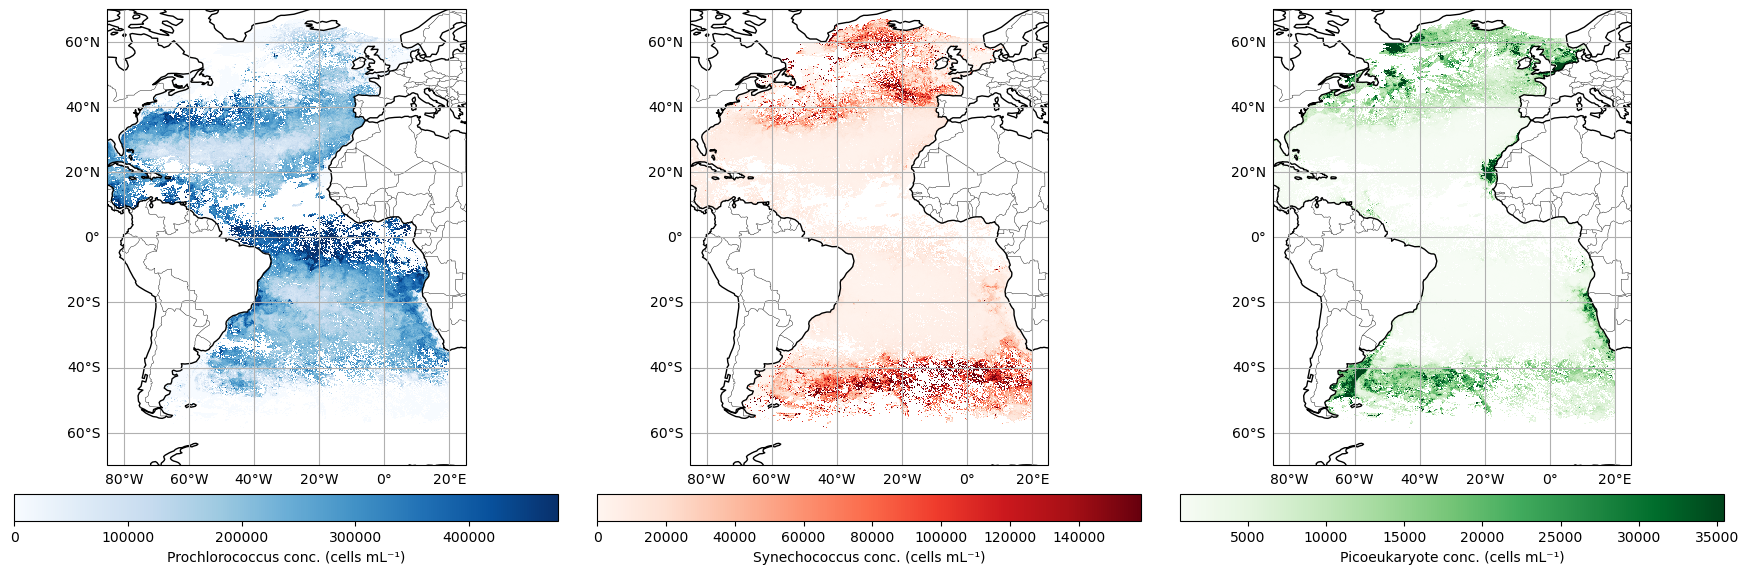

In [22]:
# Set up figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 6),
                        subplot_kw={'projection': ccrs.PlateCarree()})

# Plot each phytoplankton group 
for ax, (title, info) in zip(axs, phyto_info.items()):
    da = coarsen_da(info["data"], step=4) 
    ax.set_title(title)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False

    img = da.plot(
        ax=ax,
        cmap=info["cmap"],
        robust=True,
        add_colorbar=False
    )

    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
    cbar.set_label(info["label"])

plt.tight_layout()
plt.show()

In [ ]:
# Do some clean up of memory
plt.close('all')
gc.collect()

## TIME SERIES OF OIL SPILL

In [23]:
#load oil spill data
import pandas as pd

# Load ship data
oil = pd.read_csv("/home/jovyan/2026-proj-blue-carbon/contributor_folders/Shulhan/NOSDRA_truncate.csv")
print(oil.columns.tolist())
oil

['incidentdate', 'estimatedquantity', 'latitude', 'longitude']


,incidentdate,estimatedquantity,latitude,longitude
0,2/3/2024,7.000000,6.0564311,6.1233767
1,2/8/2024,0.500000,5.6366667,6.1877778
2,2/4/2024,10.000000,6.8551386,5.5022103
3,2/9/2024,0.000004,4.2522222,8.1605556
4,2/3/2024,332.900000,4.9861389,7.1631667
...,...,...,...,...
878,1/14/2026,0.060000,5.8377611,5.6968639
879,9/20/2024,30.000000,5.02939372,6.61232101
880,1/19/2026,157.232700,6.4397681,3.3590028
881,1/10/2026,55.000000,5.6185158,5.1703739


In [33]:
oil["incidentdate"] = pd.to_datetime(oil["incidentdate"])
oil_daily = (
    oil.groupby("incidentdate")["estimatedquantity"]
    .sum()
    .reset_index()
)


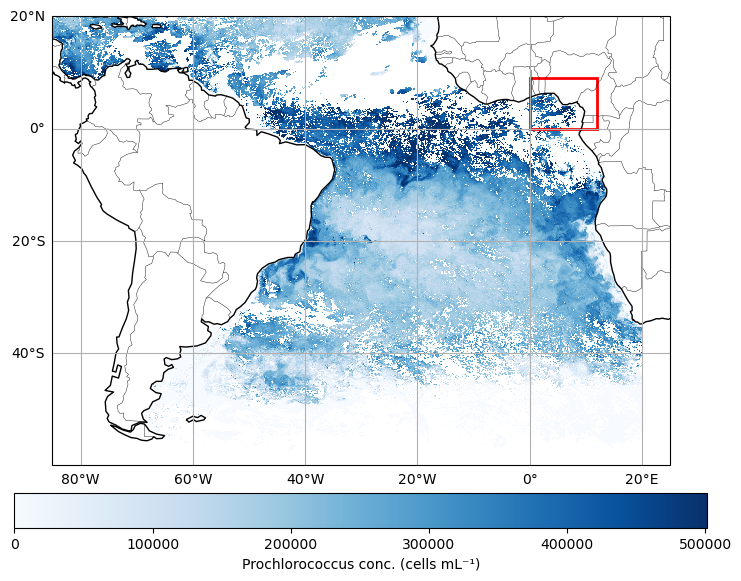

In [24]:
from matplotlib.patches import Rectangle

# Bounding box
lon_min, lon_max = 0, 12
lat_min, lat_max = 0, 9

# Choose one phytoplankton group
title = "Prochlorococcus"
data = ds["prococcus_moana"].sel(lat=slice(20, -60))
data = coarsen_da(data, step=4)
cmap = plt.cm.Blues
label = "Prochlorococcus conc. (cells mL⁻¹)"

# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Base map
ax.set_title(title)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
img = data.plot(ax=ax, cmap=cmap, robust=True, add_colorbar=False, vmin=0)

# Add bounding box
ax.add_patch(Rectangle((lon_min, lat_min),
                       lon_max - lon_min,
                       lat_max - lat_min,
                       edgecolor='red',
                       facecolor='none',
                       linewidth=2,
                       transform=ccrs.PlateCarree()))

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, shrink=0.9)
cbar.set_label(label)
plt.tight_layout()
plt.show()

fig.savefig("blue_plankton_nigdel.png")

In [35]:
import earthaccess
import xarray as xr
auth = earthaccess.login(persist=True)
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L4M_MOANA',
    temporal = ("2024-03-01", "2026-01-12"),
    granule_name="*.8D.*.4km.*"
)
len(results)

78

In [36]:
# the netcdfs do not have time so we need to get that from the results metadata
# Use the beginning of each 8-day window as the time coordinate
import numpy as np
time = [
    np.datetime64(r["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"][:10])
    for r in results
]

In [37]:
# Creating a big dataset like this takes a bit of memory
fileset = earthaccess.open(results)
dataset = xr.open_mfdataset(fileset, concat_dim="time", combine="nested")
dataset = dataset.assign_coords(time=("time", time))
dataset

QUEUEING TASKS | :   0%|          | 0/78 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/78 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/78 [00:00<?, ?it/s]

<xarray.Dataset> Size: 17GB
Dimensions:          (time: 78, lat: 3360, lon: 2640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * time             (time) datetime64[s] 624B 2024-03-05 ... 2025-11-17
  * lat              (lat) float32 13kB 69.98 69.94 69.9 ... -69.9 -69.94 -69.98
  * lon              (lon) float32 11kB -84.98 -84.94 -84.9 ... 24.9 24.94 24.98
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (time, lat, lon) float64 6GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (time, lat, lon) float64 6GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (time, lat, lon) float64 6GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (time, rgb, eightbitcolor) uint8 60kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240305_20240312.L4m.8D.MOAN...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L4M/MOANA/3.1
    data_bins:                         3191916
    data_minimum:                      0.0
    data_maximum:                      2.1167979e+12

In [38]:
# Subset to our region of interest
da=dataset.sel(lat=slice(7,3), lon=slice(3,9))

# Get the mean over the box
syn_ts = da["syncoccus_moana"].median(dim=["lat", "lon"])
pico_ts = da["picoeuk_moana"].median(dim=["lat", "lon"])
pro_ts = da["prococcus_moana"].median(dim=["lat", "lon"])

pro_ts

<xarray.DataArray 'prococcus_moana' (time: 78)> Size: 624B
dask.array<nanmedian, shape=(78,), dtype=float64, chunksize=(78,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[s] 624B 2024-03-05 2024-03-13 ... 2025-11-17
Attributes:
    long_name:      cell abundances of Prochlorococcus
    units:          cells ml^-1
    valid_min:      0
    valid_max:      600000
    reference:      Lange et al. (2020). Radiometric approach for the detecti...
    display_scale:  linear
    display_min:    0.0
    display_max:    500000.0

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7f1c01a6dbe0>.

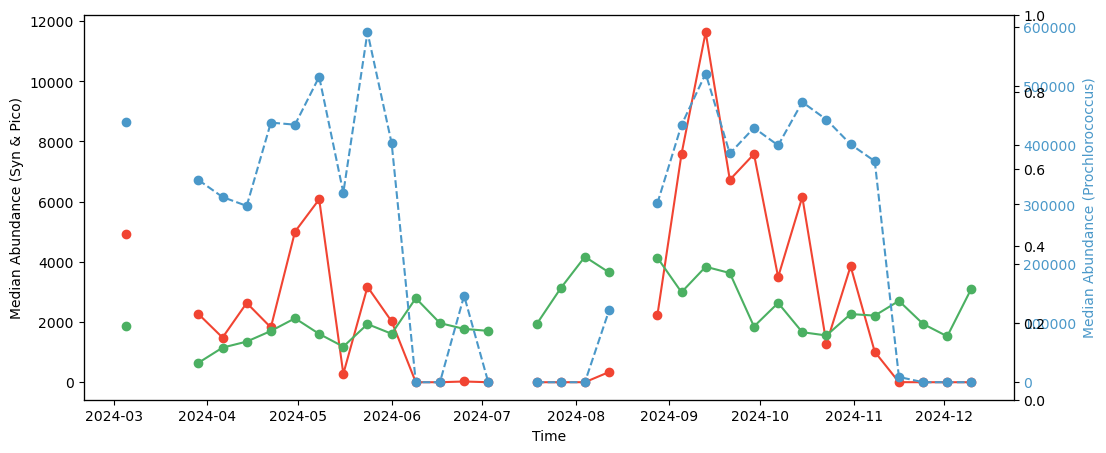

In [31]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 5))

custom_colors = {
    "Prochlorococcus": plt.cm.Blues(0.6),
    "Synechococcus": plt.cm.Reds(0.6),
    "Picoeukaryotes": plt.cm.Greens(0.6),
    "oil":plt.cm.Greys(0.6)
}

# Plot syn and pico on the left y-axis
ax1.plot(syn_ts["time"], syn_ts, 'o-', label="Synechococcus", color=custom_colors["Synechococcus"])
ax1.plot(pico_ts["time"], pico_ts, 'o-', label="Picoeukaryotes", color=custom_colors["Picoeukaryotes"])
ax1.set_xlabel("Time")
ax1.set_ylabel("Median Abundance (Syn & Pico)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Create a secondary y-axis for prococcus_moana
ax2 = ax1.twinx()
ax2.plot(pro_ts["time"], pro_ts, 'o--', label="Prochlorococcus", color=custom_colors["Prochlorococcus"])

ax2.set_ylabel("Median Abundance (Prochlorococcus)", color=custom_colors["Prochlorococcus"])
ax2.tick_params(axis='y', labelcolor=custom_colors["Prochlorococcus"])

# create oil axes
ax3=ax1.twinx()
ax3.plot(oil["incidentdate"], oil["estimatedquantity"], 'o--', label="oilspilled", color=custom_colors["oil"])
ax3.set_ylabel("Quantity of Oil Spilled", color=custom_colors["oil"])
ax3.tick_params(axis='y', labelcolor=custom_colors["Poil"])

# Combine all legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc="upper left")

# Add title and grid
plt.title("8-day Phytoplankton Abundance in Selected Box")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

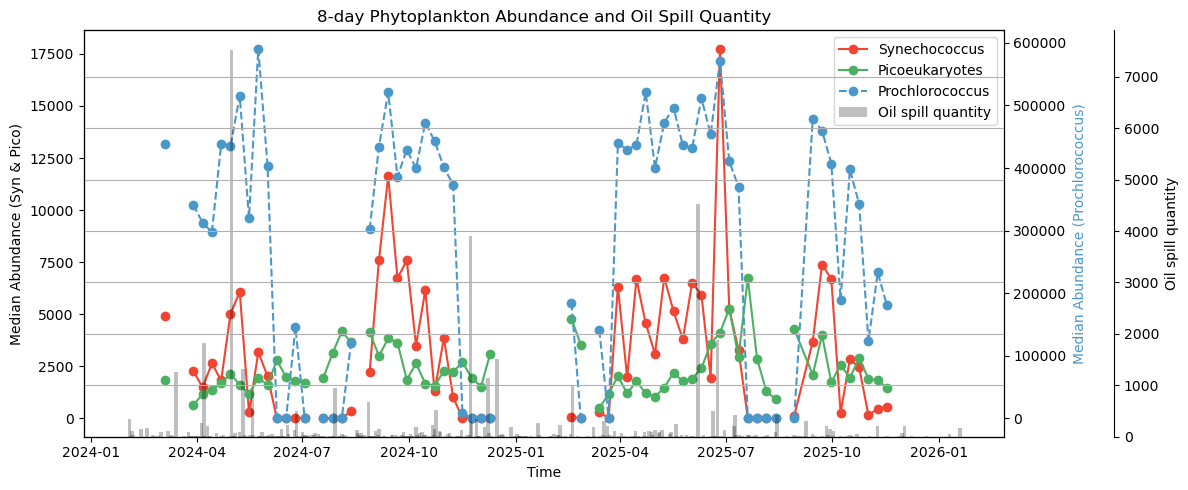

In [42]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# === Phytoplankton ===
ax1.plot(syn_ts["time"], syn_ts, 'o-',
         label="Synechococcus",
         color=plt.cm.Reds(0.6))
ax1.plot(pico_ts["time"], pico_ts, 'o-',
         label="Picoeukaryotes",
         color=plt.cm.Greens(0.6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Median Abundance (Syn & Pico)")

# === Prochlorococcus ===
ax2 = ax1.twinx()
ax2.plot(pro_ts["time"], pro_ts, 'o--',
         label="Prochlorococcus",
         color=plt.cm.Blues(0.6))
ax2.set_ylabel("Median Abundance (Prochlorococcus)",
               color=plt.cm.Blues(0.6))

# === Oil spill quantity (bars) ===
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.12))  # offset third axis
ax3.bar(
    oil_daily["incidentdate"],
    oil_daily["estimatedquantity"],
    width=3,                 # days
    color="black",
    alpha=0.25,
    label="Oil spill quantity"
)
ax3.set_ylabel("Oil spill quantity", color="black")
ax3.tick_params(axis='y', labelcolor="black")


# === Legends ===
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2 + lines3,
    labels1 + labels2 + labels3,
    loc="upper right"
)

# === Final touches ===
plt.title("8-day Phytoplankton Abundance and Oil Spill Quantity")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig.savefig("oilspillvsplanton.png")